##Resnet_model

used data : CIFAR-10(32x32x3) images in 10 classes

In [1]:
#import Library
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Activation
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy

In [2]:
#load data & nomalize data
def load_cifar10(TRAIN_BATCH_SIZE, TEST_BATCH_SIZE):
    (train_validation_images, train_validation_labels),(test_images, test_labels) = cifar10.load_data()

    train_validation_ds = tf.data.Dataset.from_tensor_slices((train_validation_images,train_validation_labels))
    #이미지&라벨 하나의 tensor로 합침
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

    n_train_validation =train_validation_images.shape[0]
    train_ratio = 0.8
    n_train = int(n_train_validation * train_ratio)
    n_validation = n_train_validation - n_train
    train_ds = train_validation_ds.take(n_train)
    remaining_ds = train_validation_ds.skip(n_train)
    validation_ds = remaining_ds.take(n_validation)
    n_test = test_images.shape[0]

    std = tf.reshape((0.2023, 0.1994, 0.2010), shape=(1, 1, 3))
    mean= tf.reshape((0.4914, 0.4822, 0.4465), shape=(1, 1, 3))
    #batch nomalization
    def train_prep(x, y):
        x = tf.cast(x, tf.float32)/255.
        x = tf.image.random_flip_left_right(x)
        x = tf.image.pad_to_bounding_box(x, 4, 4, 40, 40) # 4개씩 padding을 붙여 40x40으로 만듬
        x = tf.image.random_crop(x, (32, 32, 3)) # 랜덤하게 40x40에서 32x32를 뽑아냄
        x = (x - mean) / std #batch nomalization
        return x, y

    def test_prep(x, y):
        x = tf.cast(x, tf.float32)/255.
        x = (x - mean) / std
        return x, y

    train_ds = train_ds.map(train_prep).shuffle(1000).batch(TRAIN_BATCH_SIZE) #랜덤하게 1000번 shuffle
    validation_ds = validation_ds.map(test_prep).shuffle(1000).batch(TEST_BATCH_SIZE)
    test_ds = test_ds.map(test_prep).shuffle(1000).batch(TEST_BATCH_SIZE)

    return train_ds, validation_ds, test_ds #image + label로된 tensor형태

Contstruct Resnet-20 model (with Model Sub classing)

In [3]:
class Residual(Model):
    def __init__(self, num_channels, short_cut_conv=True, strides=1):
        super().__init__()
        self.conv1 = Conv2D(num_channels, padding='same',
                            kernel_size=3, strides=strides)
        self.bn1 = BatchNormalization()
        self.relu = Activation('relu')
        #self.dropout1 = nn.Dropout(p=0.1, inplace=False)
        self.conv2 = Conv2D(num_channels, padding='same',
                            kernel_size=3, strides=1)
        self.bn2 = BatchNormalization()
        if short_cut_conv:
            self.short_cut = Conv2D(num_channels, kernel_size=3,
                                      strides=strides, padding='same')
        else:
            self.short_cut = None

    def call(self, x):
        y = relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        if self.short_cut is not None:
            x = self.short_cut(x)
        y += x
        return relu(y)

In [4]:
class ResnetBlock(Layer):
    def __init__(self, num_channels, num_residuals,
                 first_residual_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = [] #빈 행렬 생성
        for i in range(num_residuals):
            if i==0 and first_residual_block: #rb2처음/rb3처음
                self.residual_layers.append(Residual(num_channels, short_cut_conv=False))
            elif i==0:
                self.residual_layers.append(
                    Residual(num_channels, strides=2))
            else:
                self.residual_layers.append(
                    Residual(num_channels))

    def call(self, x):
        for layer in self.residual_layers.layers:
            x = layer(x)
        return x

In [5]:
class FirstBlock(Layer):
    def __init__(self, num_channels, **kwargs):
        super(FirstBlock, self).__init__(**kwargs)
        self.conv1 = Conv2D(num_channels, kernel_size=3, strides=1, padding='same')
        self.bn1 = BatchNormalization()
        self.relu = Activation('relu')
        #self.dropout1 = nn.Dropout(p=0.1, inplace=False)
    def call(self, x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        #x=self.dropout1(x)
        return x

In [6]:
class Cifar10_Resnet20(Model):
    def __init__(self):
        super(Cifar10_Resnet20, self).__init__()

        self.fb1 = FirstBlock(16)
        self.rb1 = ResnetBlock(16, 3, first_residual_block=True)
        self.rb2 = ResnetBlock(32, 3)
        self.rb3 = ResnetBlock(64, 3)
        self.gap = GlobalAveragePooling2D()
        self.d1 = Dense(10, activation='softmax')

    def call(self, x):
        x=self.fb1(x)
        x=self.rb1(x)
        x=self.rb2(x)
        x=self.rb3(x)
        x=self.gap(x)
        #x=self.d1(x)
        return x

In [7]:
#define load_metrics
def load_metrics():
    global train_loss, train_acc
    global validation_loss, validation_acc
    global test_loss, test_acc

    train_loss = Mean()
    validation_loss = Mean()
    test_loss = Mean()
    train_acc = SparseCategoricalAccuracy()
    validation_acc = SparseCategoricalAccuracy()
    test_acc = SparseCategoricalAccuracy()

In [8]:
#define trainer
def trainer():
    global train_ds, model, loss_object, optimizer
    global train_loss, train_acc
    for x, y in train_ds:
        with tf.GradientTape() as tape:
            predictions = model(x)
            loss = loss_object(y, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_acc(y, predictions)

In [9]:
#define validation
def validation():
    global validation_ds, model, loss_object
    global validation_loss, validation_acc

    for x, y in validation_ds:
        predictions = model(x)
        loss = loss_object(y, predictions)

        validation_loss(loss)
        validation_acc(y, predictions)

In [10]:
#define train_reporter
def train_reporter():
    global epoch
    global train_loss, train_acc
    global validation_loss, validation_acc
    global train_losses, train_accs
    global validation_losses, validation_accs

    train_losses.append(train_loss.result())
    train_accs.append(train_acc.result()*100)
    validation_losses.append(validation_loss.result())
    validation_accs.append(validation_acc.result()*100)

    template = 'Train Loss: {:.4f}\t Train Accuracy : {:.2f}%\n' +\
            'Validation Loss: {:.4f}\t Validation Accuracy : {:.2f}%\n'

    print(template.format(train_loss.result(),
                        train_acc.result()*100,
                        validation_loss.result(),
                        validation_acc.result()*100))

    train_loss.reset_states()
    train_acc.reset_states()
    validation_loss.reset_states()
    validation_acc.reset_states()

In [11]:
#define plot_loss
def plot_loss():
    global train_losses, train_accs
    global validation_losses, validation_accs

    fig, axes = plt.subplots(2,1)

    axes[0].plot(train_losses, label='Train loss')
    axes[0].plot(validation_losses, label='Validation loss')
    axes[0].set_ylabel('Crossentropy')
    axes[0].legend()

    axes[1].plot(train_accs, label='Train accuracy')
    axes[1].plot(validation_accs, label='Validation accuracy')
    axes[1].set_ylabel('Accuarcy')
    axes[1].legend()
    axes[1].set_xlabel('Epochs')

In [12]:
#define tester
def tester():
    global test_ds, model, loss_object
    global test_loss, test_acc

    for x, y in test_ds:
        predictions = model(x)
        loss = loss_object(y, predictions)

        test_loss(loss)
        test_acc(y, predictions)

        template = 'Test Loss: {:.4f}\t Test Accuracy : {:.2f}%\n'

    print(template.format(test_loss.result(),
                        test_acc.result()*100))

In [13]:
def plot_result_sample():
    global test_ds, model, loss_object
    global test_loss, test_acc

    test_ds_iter = iter(test_ds)
    images, labels = next(test_ds_iter)
    predictions = model(images)

    fig, axes = plt.subplots(4, 4, figsize=(10,10))

    class_names = ['plane', 'car', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    for ax_idx, ax in enumerate(axes.flat):
        ax.imshow(images[ax_idx,...].numpy(), 'gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        true_class = class_names[labels[ax_idx,0].numpy()]
        pred_class = class_names[np.argmax(predictions[ax_idx].numpy())]

        if true_class==pred_class:
            ax.set_title('{}=={}'.format(true_class, pred_class),
                         fontdict={'weight': 'bold', 'color': 'green'})
        else:
            ax.set_title('{}=!{}'.format(true_class, pred_class),
                         fontdict={'weight': 'bold', 'color': 'red'})

In [14]:
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128

train_ds, validation_ds, test_ds = load_cifar10(TRAIN_BATCH_SIZE,TEST_BATCH_SIZE)

170498071/170498071 [==============================] - 2s 0us/step


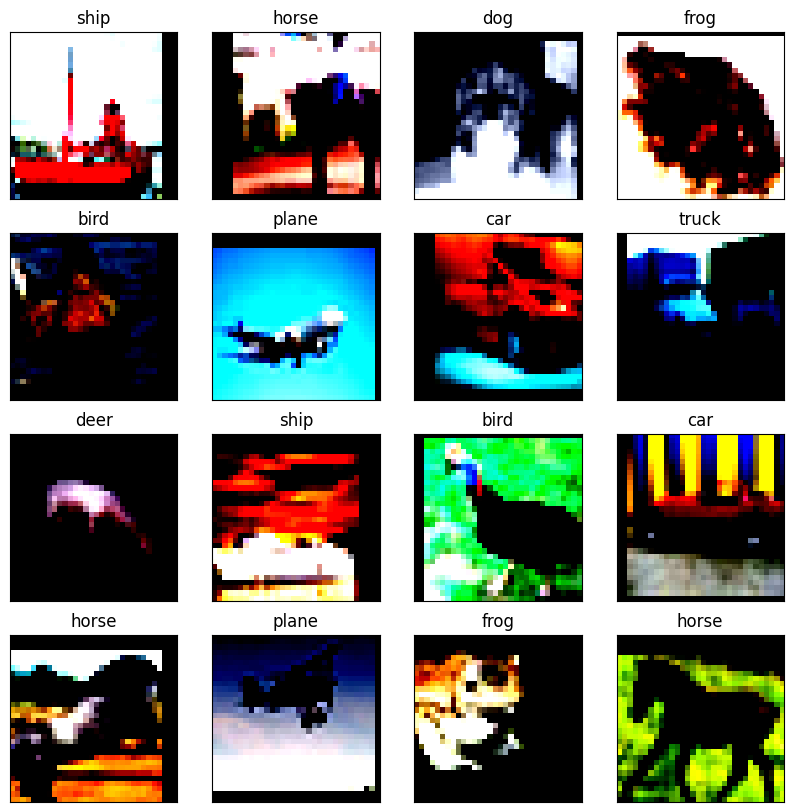

In [15]:
train_ds_iter = iter(train_ds)
images, labels = next(train_ds_iter)

class_names = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for ax_idx, ax in enumerate(axes.flat):
    ax.imshow(images[ax_idx,...].numpy(), 'gray')
    ax.set_title('{}'.format(class_names[labels[ax_idx,0]]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if ax_idx > 15:
        break

In [16]:
#model training
model = Cifar10_Resnet20()

In [17]:
load_metrics()

loss_object = SparseCategoricalCrossentropy()
optimizer = SGD(learning_rate=0.01, momentum=0.9)

EPOCHS = 20

train_losses, train_accs = [], []
validation_losses, validation_accs = [], []

for epoch in range(EPOCHS):
    trainer()
    validation()
    print('Epoch : {}'.format(epoch+1))
    train_reporter()

Epoch : 1
Train Loss: 3.7336	 Train Accuracy : 9.91%
Validation Loss: 3.7192	 Validation Accuracy : 10.25%

Epoch : 2
Train Loss: 3.7227	 Train Accuracy : 9.94%
Validation Loss: 3.7192	 Validation Accuracy : 10.25%

Epoch : 3
Train Loss: 3.7228	 Train Accuracy : 9.94%
Validation Loss: 3.7192	 Validation Accuracy : 10.25%

Epoch : 4
Train Loss: 3.7295	 Train Accuracy : 9.94%
Validation Loss: 3.7708	 Validation Accuracy : 10.25%

Epoch : 5
Train Loss: 3.7600	 Train Accuracy : 9.94%
Validation Loss: 3.7712	 Validation Accuracy : 10.25%

Epoch : 6
Train Loss: 3.7598	 Train Accuracy : 9.94%
Validation Loss: 3.7711	 Validation Accuracy : 10.25%

Epoch : 7
Train Loss: 3.7599	 Train Accuracy : 9.94%
Validation Loss: 3.7712	 Validation Accuracy : 10.25%

Epoch : 8
Train Loss: 3.7598	 Train Accuracy : 9.94%
Validation Loss: 3.7712	 Validation Accuracy : 10.25%

Epoch : 9
Train Loss: 3.7599	 Train Accuracy : 9.94%
Validation Loss: 3.7711	 Validation Accuracy : 10.25%

Epoch : 10
Train Loss: 3.759

In [18]:
tester()

Test Loss: 3.7712	 Test Accuracy : 10.00%



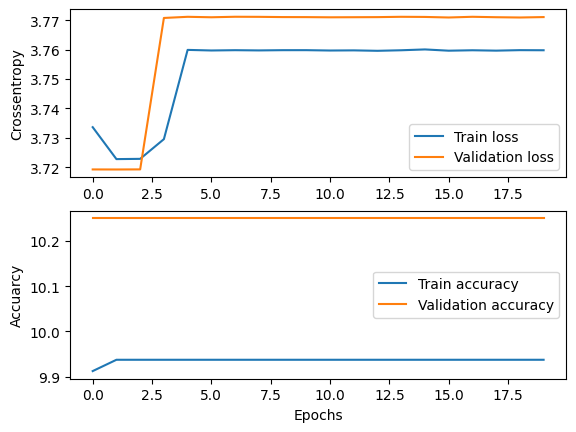

In [19]:
plot_loss()

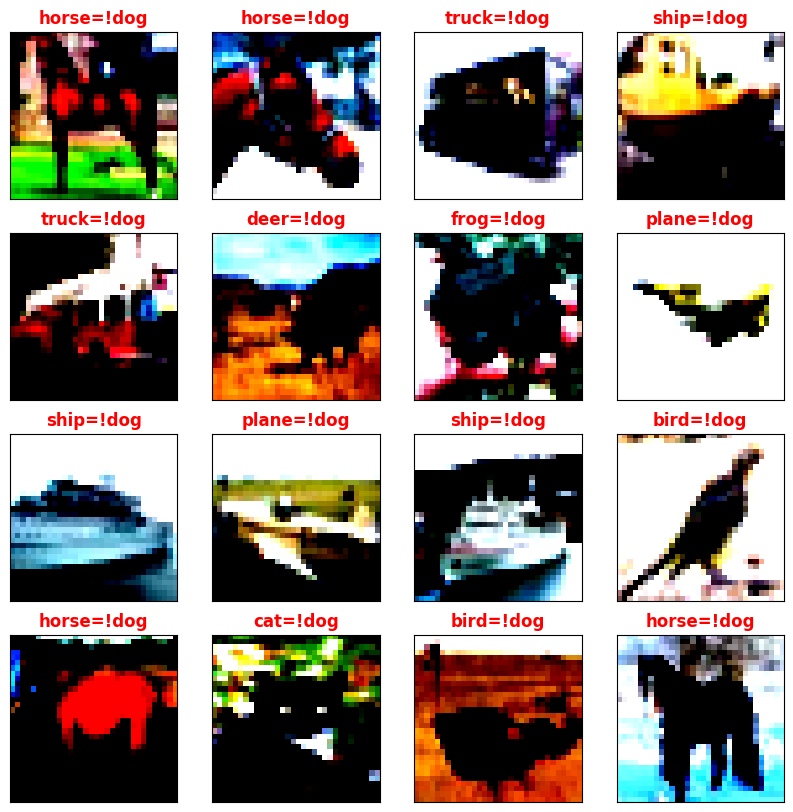

In [20]:
plot_result_sample()